# Extract data from CSV files

In [ ]:
#!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 11.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840648 sha256=7f9e6971b64b70fb365b1c2d11c9934c09d7de7361233d811ae2c715a2c2040d
  Stored in directory: /home/elena/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
from pyspark.sql import *
spark = SparkSession.builder.appName("Proj").getOrCreate()

24/12/03 19:46:27 WARN Utils: Your hostname, CYB-L resolves to a loopback address: 127.0.1.1; using 192.168.7.113 instead (on interface wlp0s20f3)
24/12/03 19:46:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 19:46:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## contacts.csv

In [3]:
df_con = spark.read.option('header', 'true').csv("data/contacts.csv", inferSchema=True)
df_con.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+----------------+-----------------+--------+--------------+------------------------------------+---------------------+----------------------+
|       id_guest_anon|        id_host_anon|     id_listing_anon|ts_interaction_first|  ts_reply_at_first|ts_accepted_at_first|      ts_booking_at|ds_checkin_first|ds_checkout_first|m_guests|m_interactions|m_first_message_length_in_characters|contact_channel_first|guest_user_stage_first|
+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+----------------+-----------------+--------+--------------+------------------------------------+---------------------+----------------------+
|da8656a1-51af-4f3...|5426897d-960d-401...|a408a8b2-0d44-451...| 2016-04-21 02:55:53|2016-04-21 03:15:00| 2016-04-21 03:15:00|2016-04-21

In [4]:
df_con.printSchema()

root
 |-- id_guest_anon: string (nullable = true)
 |-- id_host_anon: string (nullable = true)
 |-- id_listing_anon: string (nullable = true)
 |-- ts_interaction_first: timestamp (nullable = true)
 |-- ts_reply_at_first: timestamp (nullable = true)
 |-- ts_accepted_at_first: timestamp (nullable = true)
 |-- ts_booking_at: timestamp (nullable = true)
 |-- ds_checkin_first: date (nullable = true)
 |-- ds_checkout_first: date (nullable = true)
 |-- m_guests: double (nullable = true)
 |-- m_interactions: integer (nullable = true)
 |-- m_first_message_length_in_characters: double (nullable = true)
 |-- contact_channel_first: string (nullable = true)
 |-- guest_user_stage_first: string (nullable = true)



In [5]:
count_dup_rows = df_con.count() - df_con.distinct().count()
print(f"Number of duplicate rows: {count_dup_rows}")


Number of duplicate rows: 0


In [6]:
Dict_Null = {col:df_con.filter(df_con[col].isNull()).count() for col in df_con.columns}
print(f"Number of Null values in each column: ")
for key, value in Dict_Null.items():
    print(key, ": ", value)

Number of Null values in each column: 
id_guest_anon :  0
id_host_anon :  0
id_listing_anon :  0
ts_interaction_first :  0
ts_reply_at_first :  2032
ts_accepted_at_first :  11472
ts_booking_at :  16300
ds_checkin_first :  0
ds_checkout_first :  0
m_guests :  1
m_interactions :  0
m_first_message_length_in_characters :  0
contact_channel_first :  0
guest_user_stage_first :  0


## listings.csv

In [7]:
df_lis = spark.read.option('header', 'true').csv("data/listings.csv", inferSchema=True)
df_lis.show(5)

+--------------------+---------------+--------------------+-------------+
|     id_listing_anon|      room_type|listing_neighborhood|total_reviews|
+--------------------+---------------+--------------------+-------------+
|71582793-e5f8-46d...|   Private room|           -unknown-|          0.0|
|a1a3f728-e21f-443...|Entire home/apt|          Copacabana|          0.0|
|353a68be-ecf9-4b7...|Entire home/apt|     Barra da Tijuca|          3.0|
|b9ae1908-0486-40a...|Entire home/apt|                Lapa|          4.0|
|fa0290ef-7881-448...|Entire home/apt|           -unknown-|          0.0|
+--------------------+---------------+--------------------+-------------+
only showing top 5 rows



In [8]:
df_lis.printSchema()

root
 |-- id_listing_anon: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- listing_neighborhood: string (nullable = true)
 |-- total_reviews: double (nullable = true)



In [9]:
count_dup_rows = df_lis.count() - df_lis.distinct().count()
print(f"Number of duplicate rows: {count_dup_rows}")

Number of duplicate rows: 0


In [10]:
Dict_Null = {col:df_lis.filter(df_lis[col].isNull()).count() for col in df_lis.columns}
print(f"Number of Null values in each column: ")
for key, value in Dict_Null.items():
    print(key, ": ", value)

Number of Null values in each column: 
id_listing_anon :  0
room_type :  0
listing_neighborhood :  0
total_reviews :  0


## users.csv

In [11]:
df_user = spark.read.option('header', 'true').csv("data/users.csv", inferSchema=True)
df_user.show(5)

+--------------------+-------+---------------------+
|        id_user_anon|country|words_in_user_profile|
+--------------------+-------+---------------------+
|1d16a001-31a2-494...|     FR|                    0|
|42607e0a-86c0-472...|     AR|                    0|
|25f85eb5-a700-44e...|     BR|                    0|
|55abeba0-18ef-4c5...|     BR|                    1|
|5d62d35a-7d6d-45d...|     BR|                   98|
+--------------------+-------+---------------------+
only showing top 5 rows



In [12]:
df_user.printSchema()

root
 |-- id_user_anon: string (nullable = true)
 |-- country: string (nullable = true)
 |-- words_in_user_profile: integer (nullable = true)



In [13]:
count_dup_rows = df_user.count() - df_user.distinct().count()
print(f"Number of duplicate rows: {count_dup_rows}")

Number of duplicate rows: 68


In [14]:
df_user = df_user.dropDuplicates()

In [15]:
count_dup_rows = df_user.count() - df_user.distinct().count()
print(f"Number of duplicate rows: {count_dup_rows}")

Number of duplicate rows: 0


In [16]:
Dict_Null = {col:df_user.filter(df_user[col].isNull()).count() for col in df_user.columns}
print(f"Number of Null values in each column: ")
for key, value in Dict_Null.items():
    print(key, ": ", value)

Number of Null values in each column: 
id_user_anon :  0
country :  0
words_in_user_profile :  0


## Explore Listings

In [17]:
df_lis.orderBy("total_reviews").tail(5)

[Row(id_listing_anon='dc3a2aaf-fae4-4b2f-9694-6dc978e8760e', room_type='Entire home/apt', listing_neighborhood='Santa Teresa', total_reviews=182.0),
 Row(id_listing_anon='ead9b36a-1b42-4b2d-a367-baf27dc0251d', room_type='Entire home/apt', listing_neighborhood='Copacabana', total_reviews=182.0),
 Row(id_listing_anon='c0a6e46f-ea7e-43b4-aa79-87081df96949', room_type='Entire home/apt', listing_neighborhood='Copacabana', total_reviews=185.0),
 Row(id_listing_anon='9bbe37a8-2688-4a23-bacf-405535769d88', room_type='Entire home/apt', listing_neighborhood='Ipanema', total_reviews=209.0),
 Row(id_listing_anon='77b09acc-9bc4-4843-9911-e76f4a73d142', room_type='Private room', listing_neighborhood='Santa Teresa', total_reviews=268.0)]

In [18]:
df_lis.groupBy("room_type").count().show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  372|
|Entire home/apt| 9647|
|   Private room| 3019|
+---------------+-----+



In [19]:
df_lis.groupBy("listing_neighborhood").count().sort("count", ascending=False).show()

+--------------------+-----+
|listing_neighborhood|count|
+--------------------+-----+
|           -unknown-| 6221|
|          Copacabana| 2531|
|             Ipanema| 1041|
|     Barra da Tijuca|  593|
|              Leblon|  458|
|            Botafogo|  345|
|        Santa Teresa|  243|
|            Flamengo|  171|
|                Lapa|  171|
|                Leme|  168|
|Recreio dos Bande...|  164|
|         Laranjeiras|  120|
|              Tijuca|   82|
|               Lagoa|   68|
|              Glória|   68|
|              Catete|   59|
|               Gávea|   54|
|     Jardim Botânico|   52|
|              Centro|   51|
|             Humaitá|   43|
+--------------------+-----+
only showing top 20 rows



## Explore users

In [20]:
df_user.groupBy("country").count().sort("count", ascending=False).show()

+-------+-----+
|country|count|
+-------+-----+
|     BR|19568|
|     US| 2878|
|     AR| 1770|
|     FR| 1164|
|     GB|  975|
|     DE|  610|
|     CL|  410|
|     CA|  387|
|     AU|  367|
|     NL|  271|
|     ES|  243|
|     CO|  241|
|     IT|  228|
|     CH|  227|
|     UY|  206|
|     MX|  173|
|     PE|  119|
|     PT|  110|
|     BE|  100|
|     DK|   77|
+-------+-----+
only showing top 20 rows



## Join all tables

In [40]:
df_joined = df_con.join(df_user, df_user.id_user_anon == df_con.id_guest_anon)
df_joined = df_joined.join(df_lis, df_lis.id_listing_anon == df_joined.id_listing_anon) 
df_joined.show(10)

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+----------------+-----------------+--------+--------------+------------------------------------+---------------------+----------------------+--------------------+-------+---------------------+--------------------+---------------+--------------------+-------------+
|       id_guest_anon|        id_host_anon|     id_listing_anon|ts_interaction_first|  ts_reply_at_first|ts_accepted_at_first|      ts_booking_at|ds_checkin_first|ds_checkout_first|m_guests|m_interactions|m_first_message_length_in_characters|contact_channel_first|guest_user_stage_first|        id_user_anon|country|words_in_user_profile|     id_listing_anon|      room_type|listing_neighborhood|total_reviews|
+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+----------------+---------------

Average time between a guest's first interaction and the host reply

In [22]:
from pyspark.sql.functions import col, unix_timestamp, avg

df_joined = df_joined.withColumn(
    "interaction_to_reply",
    (unix_timestamp(col("ts_reply_at_first")) - unix_timestamp(col("ts_interaction_first"))) / 3600
).withColumn(
    "interaction_to_accept",
    (unix_timestamp(col("ts_accepted_at_first")) - unix_timestamp(col("ts_interaction_first"))) / 3600
)

average_times = df_joined.select(
    avg("interaction_to_reply").alias("avg_interaction_to_reply_hours"),
    avg("interaction_to_accept").alias("avg_interaction_to_accept_hours")
)

average_times.show()


+------------------------------+-------------------------------+
|avg_interaction_to_reply_hours|avg_interaction_to_accept_hours|
+------------------------------+-------------------------------+
|            14.759942231247203|             13.058290621721554|
+------------------------------+-------------------------------+



In [24]:

total_interactions = df_joined.count()

replied_interactions = df_joined.filter(df_joined.ts_reply_at_first.isNotNull()).count()

accepted_interactions = df_joined.filter(df_joined.ts_accepted_at_first.isNotNull()).count()

reply_rate = (replied_interactions / total_interactions) * 100
acceptance_rate = (accepted_interactions / total_interactions) * 100

print(f"Reply Rate: {reply_rate:.2f}%")
print(f"Acceptance Rate: {acceptance_rate:.2f}%")


Reply Rate: 92.71%
Acceptance Rate: 58.86%


Are longer first messages correlated with higher acceptance rates or quicker responses from hosts?

In [ ]:
from pyspark.sql.functions import col, unix_timestamp

df_joined = df_joined.withColumn(
    "time_to_reply_hours",
    (unix_timestamp("ts_reply_at_first") - unix_timestamp("ts_interaction_first")) / 3600
).withColumn(
    "time_to_accept_hours",
    (unix_timestamp("ts_accepted_at_first") - unix_timestamp("ts_interaction_first")) / 3600
)

correlation_length_reply = df_joined.filter(col("time_to_reply_hours").isNotNull()) \
    .stat.corr("m_first_message_length_in_characters", "time_to_reply_hours")

correlation_length_accept = df_joined.filter(col("time_to_accept_hours").isNotNull()) \
    .stat.corr("m_first_message_length_in_characters", "time_to_accept_hours")

print(f"Correlation between message length and reply time: {correlation_length_reply:.2f}")
print(f"Correlation between message length and accept time: {correlation_length_accept:.2f}")


Correlation between message length and reply time: 0.02
Correlation between message length and accept time: 0.02


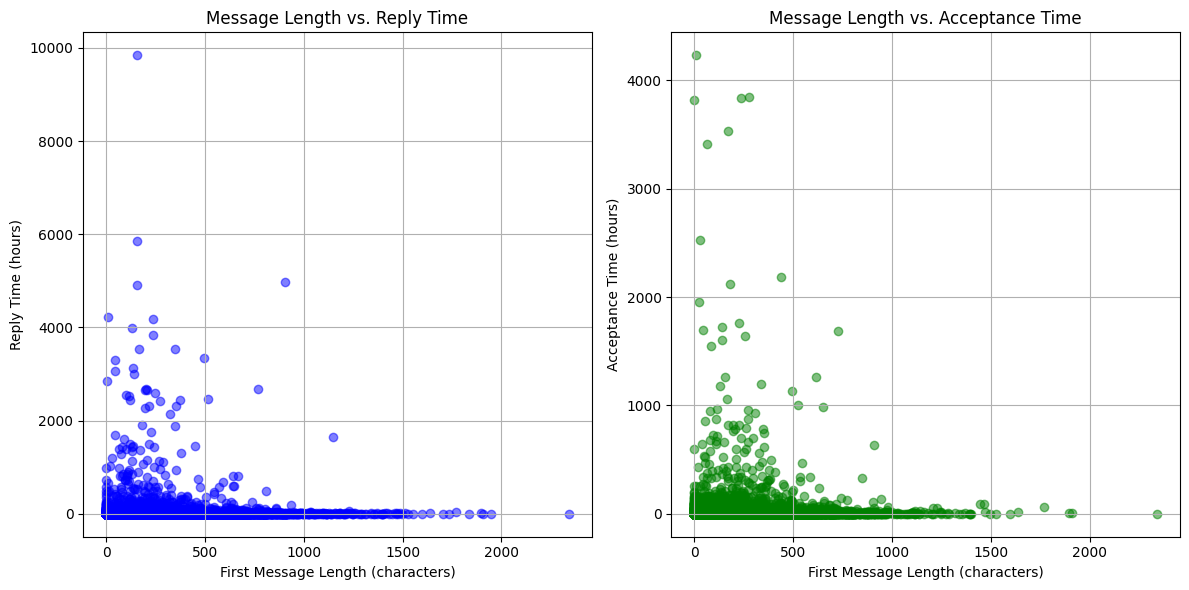

In [33]:
import matplotlib.pyplot as plt

df_pandas = df_joined.select(
    "m_first_message_length_in_characters", 
    "time_to_reply_hours",
    "time_to_accept_hours"
).toPandas()



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_pandas["m_first_message_length_in_characters"], df_pandas["time_to_reply_hours"], alpha=0.5, color='blue')
plt.title("Message Length vs. Reply Time")
plt.xlabel("First Message Length (characters)")
plt.ylabel("Reply Time (hours)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_pandas["m_first_message_length_in_characters"], df_pandas["time_to_accept_hours"], alpha=0.5, color='green')
plt.title("Message Length vs. Acceptance Time")
plt.xlabel("First Message Length (characters)")
plt.ylabel("Acceptance Time (hours)")
plt.grid(True)

plt.tight_layout()
plt.show()


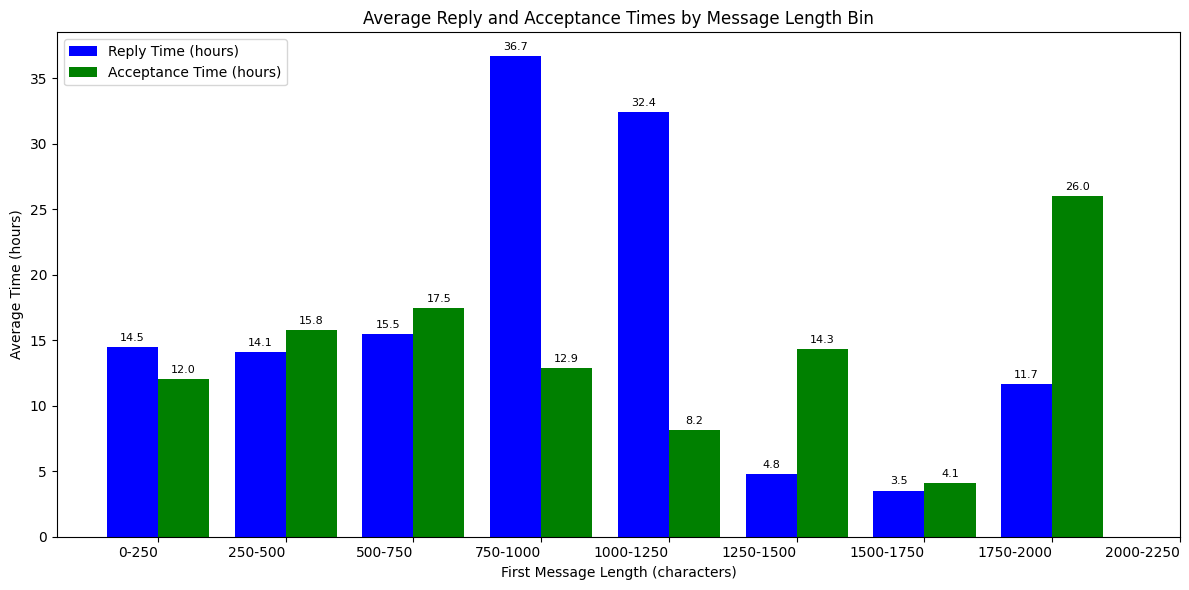

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Binning the message lengths
bins = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df_pandas['length_bin'] = pd.cut(df_pandas['m_first_message_length_in_characters'], bins=bins, labels=labels, right=False)

# Calculating averages for each bin
grouped = df_pandas.groupby('length_bin').agg({
    'time_to_reply_hours': 'mean',
    'time_to_accept_hours': 'mean'
}).reset_index()


x = np.arange(len(labels))  
width = 0.4 

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width/2, grouped['time_to_reply_hours'], width, label='Reply Time (hours)', color='blue')
bar2 = ax.bar(x + width/2, grouped['time_to_accept_hours'], width, label='Acceptance Time (hours)', color='green')

ax.set_xlabel('First Message Length (characters)')
ax.set_ylabel('Average Time (hours)')
ax.set_title('Average Reply and Acceptance Times by Message Length Bin')
ax.set_xticks(x)
ax.set_xticklabels(labels, ha='right')
ax.legend()

for bar in bar1:
    height = bar.get_height()
    if not pd.isna(height):
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        
for bar in bar2:
    height = bar.get_height()
    if not pd.isna(height):
        ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


Do guests with more detailed profiles (e.g., higher words_in_user_profile) have better booking success rates?

In [54]:
from pyspark.sql.functions import unix_timestamp, when

df_joined = df_joined.withColumn(
    "booking_success", when(df_joined["ts_booking_at"].isNotNull(), 1).otherwise(0)
)
correlation_words_success = df_joined.stat.corr("words_in_user_profile", "booking_success")

print(f"Correlation between words in user profile and accept time: {correlation_length_reply:.2f}")

Correlation between words in user profile and accept time: 0.02


 How does guest behavior vary by country of origin in terms of response times or interaction count?

In [62]:
from pyspark.sql.functions import avg

country_behavior_analysis = df_joined.groupBy("country").agg(
    avg("time_to_reply_hours").alias("avg_time_to_reply_hours"),
    avg("time_to_accept_hours").alias("avg_time_to_accept_hours"),
    avg("m_interactions").alias("avg_interactions")
).orderBy("avg_time_to_reply_hours", ascending=True)


country_behavior_analysis.show()


+-------+-----------------------+------------------------+-----------------+
|country|avg_time_to_reply_hours|avg_time_to_accept_hours| avg_interactions|
+-------+-----------------------+------------------------+-----------------+
|     MK|                   NULL|                    NULL|              1.0|
|     IQ|                   NULL|                    NULL|              1.0|
|     NG|                    0.0|                     0.0|             11.0|
|     JE|                    0.0|    1.388888888888889E-4|              4.5|
|     FJ|                    0.0|                     0.0|              9.0|
|     AW|   1.388888888888889E-4|    1.388888888888889E-4|              3.5|
|     MZ|   2.777777777777778E-4|    2.777777777777778E-4|             10.0|
|     MU|   2.777777777777778E-4|    2.777777777777778E-4|             40.0|
|     MN|   2.777777777777778E-4|    2.777777777777778E-4|             11.0|
|     NC|   2.777777777777778E-4|    2.777777777777778E-4|             12.0|

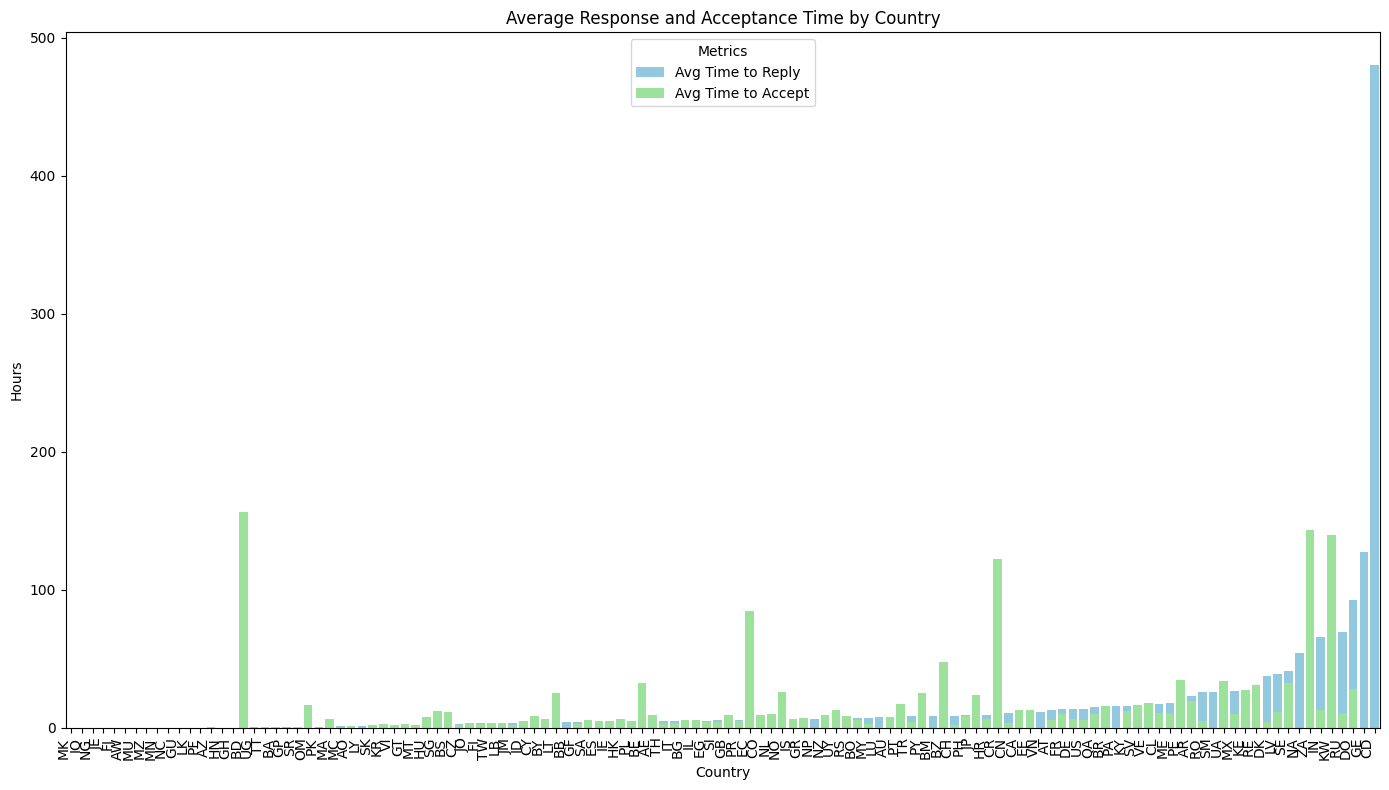

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

country_behavior_pandas = country_behavior_analysis.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(data=country_behavior_pandas, x="country", y="avg_time_to_reply_hours", color='skyblue', label='Avg Time to Reply')
sns.barplot(data=country_behavior_pandas, x="country", y="avg_time_to_accept_hours", color='lightgreen', label='Avg Time to Accept')
plt.xlabel('Country')
plt.ylabel('Hours')
plt.title('Average Response and Acceptance Time by Country')
plt.xticks(rotation=90, ha='right')
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


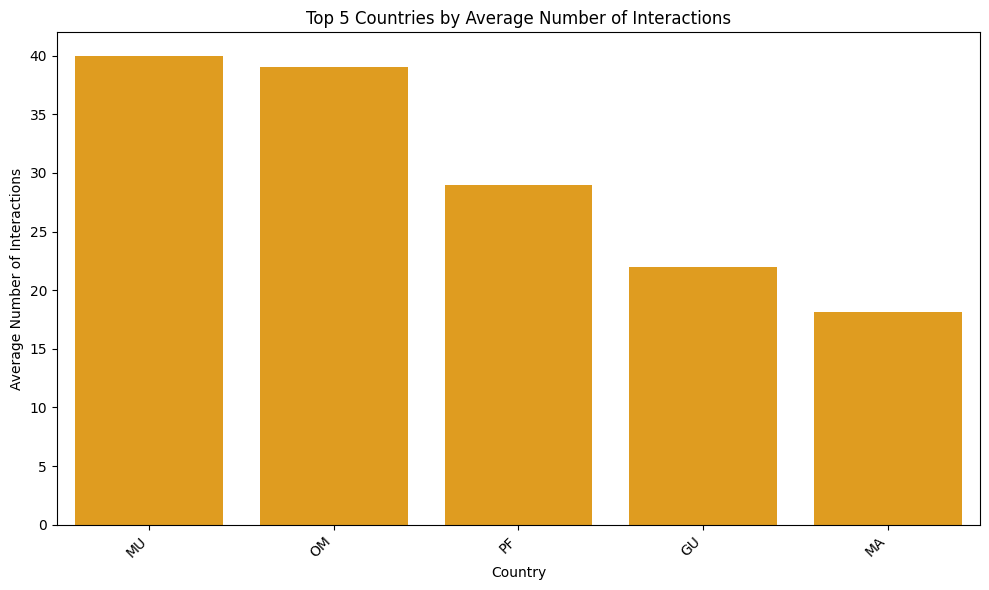

In [66]:

top_5_countries = country_behavior_analysis.orderBy("avg_interactions", ascending=False).limit(5)

top_5_countries_pandas = top_5_countries.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_countries_pandas, x="country", y="avg_interactions", color='orange')
plt.xlabel('Country')
plt.ylabel('Average Number of Interactions')
plt.title('Top 5 Countries by Average Number of Interactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Which contact_channel_first is associated with the highest booking rates or quickest host responses?

In [ ]:
from pyspark.sql.functions import avg

channel_analysis = df_joined.groupBy("contact_channel_first").agg(
    avg("booking_success").alias("avg_booking_success"),
    avg("time_to_reply_hours").alias("avg_time_to_reply_hours"),
    avg("time_to_accept_hours").alias("avg_time_to_accept_hours")
)


channel_analysis_sorted = channel_analysis.orderBy("avg_booking_success", ascending=False)

channel_analysis_sorted.show()


+---------------------+-------------------+-----------------------+------------------------+
|contact_channel_first|avg_booking_success|avg_time_to_reply_hours|avg_time_to_accept_hours|
+---------------------+-------------------+-----------------------+------------------------+
|         instant_book|                1.0|     1.3827707638162496|      1.7723520842671443|
|              book_it|  0.476093712646426|     13.624032831311926|       17.72412244496854|
|           contact_me|0.07101652634861241|     23.170280755925354|       23.22860432121283|
+---------------------+-------------------+-----------------------+------------------------+



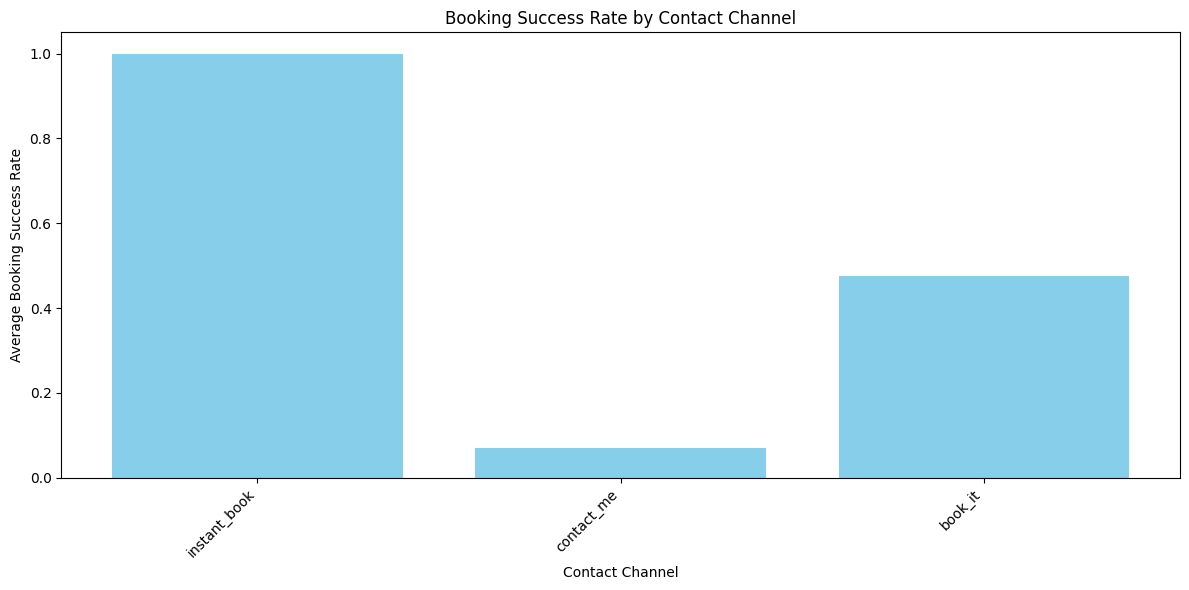

In [ ]:
import matplotlib.pyplot as plt

channel_analysis_pandas = channel_analysis.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(channel_analysis_pandas["contact_channel_first"], channel_analysis_pandas["avg_booking_success"], color='skyblue')
plt.xlabel('Contact Channel')
plt.ylabel('Average Booking Success Rate')
plt.title('Booking Success Rate by Contact Channel')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


 Are some contact channels more effective for certain room types or neighborhoods?

In [59]:
from pyspark.sql.functions import avg

channel_room_analysis = df_joined.groupBy("contact_channel_first", "room_type").agg(
    avg("booking_success").alias("avg_booking_success")
).orderBy("avg_booking_success", ascending=False)

channel_neighborhood_analysis = df_joined.groupBy("contact_channel_first", "listing_neighborhood").agg(
    avg("booking_success").alias("avg_booking_success")
).orderBy("avg_booking_success", ascending=False)


channel_room_analysis.show()
channel_neighborhood_analysis.show()


+---------------------+---------------+--------------------+
|contact_channel_first|      room_type| avg_booking_success|
+---------------------+---------------+--------------------+
|         instant_book|   Private room|                 1.0|
|         instant_book|Entire home/apt|                 1.0|
|         instant_book|    Shared room|                 1.0|
|              book_it|   Private room|  0.5118460019743336|
|              book_it|    Shared room|  0.4656084656084656|
|              book_it|Entire home/apt| 0.46463989595187777|
|           contact_me|   Private room| 0.07951429690560126|
|           contact_me|Entire home/apt| 0.06947093665294649|
|           contact_me|    Shared room|0.050955414012738856|
+---------------------+---------------+--------------------+

+---------------------+--------------------+-------------------+
|contact_channel_first|listing_neighborhood|avg_booking_success|
+---------------------+--------------------+-------------------+
|          

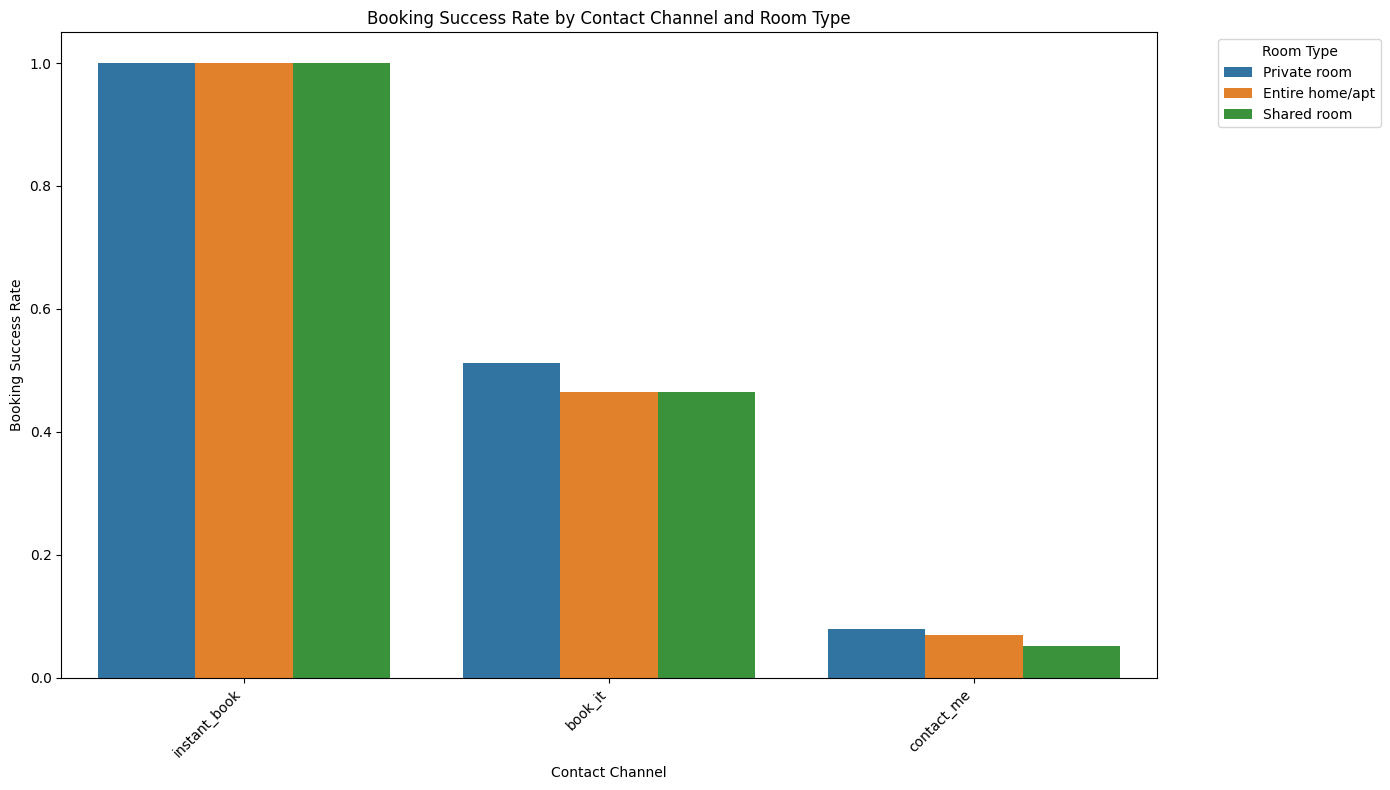

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns


channel_room_pandas = channel_room_analysis.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(data=channel_room_pandas, x="contact_channel_first", y="avg_booking_success", hue="room_type")
plt.xlabel("Contact Channel")
plt.ylabel("Booking Success Rate")
plt.title("Booking Success Rate by Contact Channel and Room Type")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Room Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_5526/2129000398.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


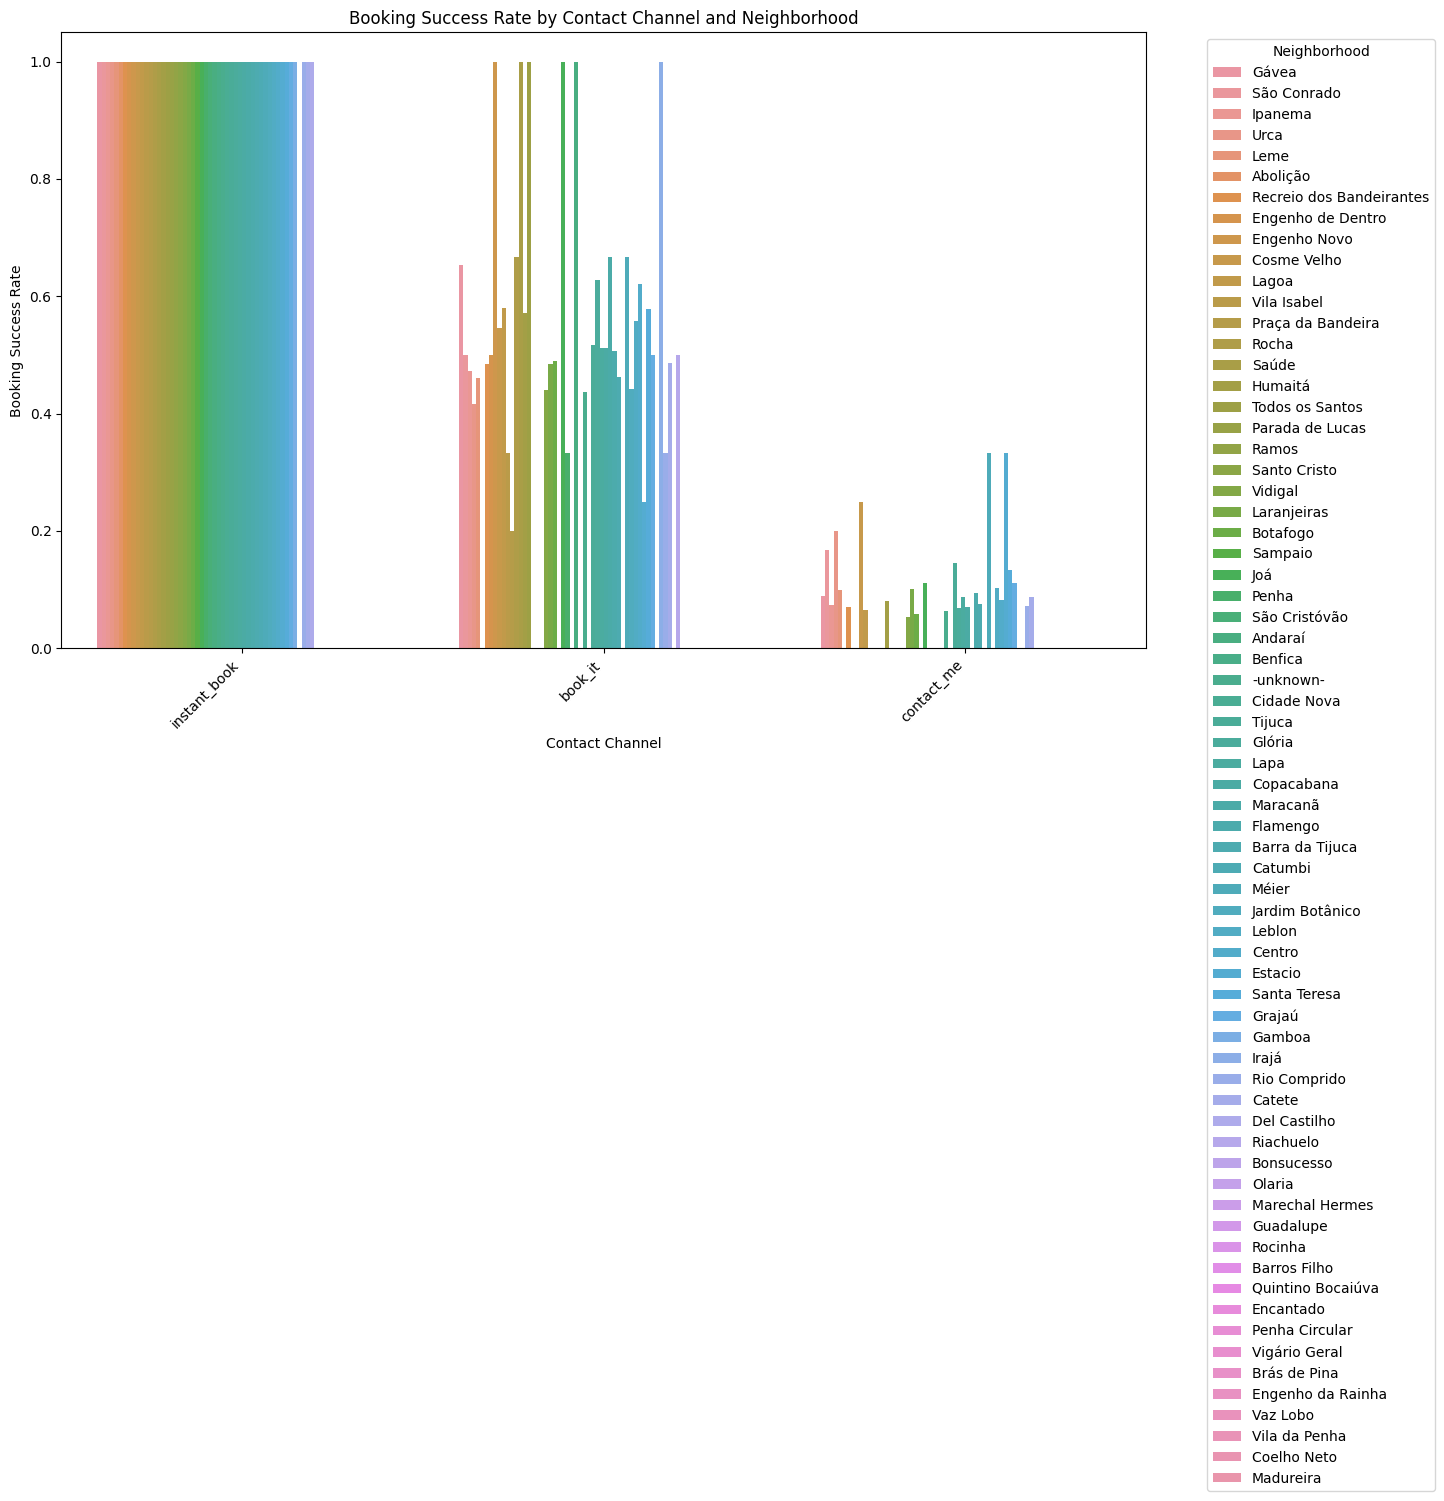

In [61]:

channel_neighborhood_pandas = channel_neighborhood_analysis.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(data=channel_neighborhood_pandas, x="contact_channel_first", y="avg_booking_success", hue="listing_neighborhood")
plt.xlabel("Contact Channel")
plt.ylabel("Booking Success Rate")
plt.title("Booking Success Rate by Contact Channel and Neighborhood")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
